In [12]:
from sys import path as syspath
syspath.append('../src/python/')

In [31]:
import os
from functools import reduce as freduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors, cm
from matplotlib import patches as mpatches
from statsmodels.graphics.boxplots import violinplot as svplot
from scipy.special import binom as sbinom
import seaborn as sns

from RealData import RealData  # local import

from IPython.display import clear_output

In [22]:
# Set global plotting style
sns.set_style('darkgrid')

## Reference calculations

In [23]:
def HarmonicNumber(n):
    summand = 0
    for i in range(n):
        k = i + 1
        summand += + 1/k
    return summand

def HarmonicNumber2(n):
    summand = 0
    for i in range(n):
        k = i + 1
        summand += 1/k ** 2
    return summand

def SackinYule(n):
    Hn = HarmonicNumber(n)
    Hn2 = HarmonicNumber2(n)
    expectation = 2 * n * (Hn - 1)
    variance = 7 * n**2 - 4*n ** 2 * Hn2 - 2*n*Hn - n
    return expectation, variance

In [24]:
def doubleFactorial(n):
    ans = freduce(int.__mul__, range(n,0,-2))
    return ans

def SackinUniform(n):
    num = doubleFactorial(2*n - 2)
    denom = doubleFactorial(2*n-3)
    ratio = num/denom
    expected = n * (ratio - 1)
    variance = n * (10 * n ** 2 - 3*n - 1) / 3- int(sbinom(n+1, 2)) * ratio - n ** 2 * ratio ** 2
    return expected, variance

## Data loading

In [25]:
dataDict = {}
letters = "5a"
expected_names = ["matrix_trans", "matrix_phylo", "matrix_seqs_raw", "matrix_seqs"]
for size in [15, 50]:
    ddict = {}
    data_dir = f'../synth_data/SEEPS_{letters}/{size}/'
    key = 'None'
    files = os.listdir(data_dir)
    print(os.path.join(data_dir, files[0]))
    dataDict[size] = RealData(source=os.path.join(data_dir, files[0]), 
                              source_type="parquet", shuffle=False,
                              expected_names = expected_names)
    # PairMat(os.path.join(data_dir, files[0]), method=key)

clear_output(wait=False)

print('Finished all data import and sorting.', flush=True)

Finished all data import and sorting.


In [26]:
dataDict1 = {}
letters = "5d"
expected_names = ["matrix_trans", "matrix_phylo", "matrix_seqs_raw", "matrix_seqs"]
for size in [15, 50]:
    ddict = {}
    data_dir = f'../synth_data/SEEPS_{letters}/{size}/'
    key = 'None'
    files = os.listdir(data_dir)
    
    dataDict1[size] = RealData(source=os.path.join(data_dir, files[0]), 
                              source_type="parquet", shuffle=False,
                              expected_names = expected_names)
    # PairMat(os.path.join(data_dir, files[0]), method=key)

clear_output(wait=False)

print('Finished all data import and sorting.', flush=True)

Finished all data import and sorting.


In [32]:
df_all_list = []
for sz in [15, 50]:
    for stype in ["Transmission History", "Phylogeny"]:
        for p, data_source in zip([0.9, 0.1], [dataDict, dataDict1]):
            print(sz, stype, p)
            if stype == "Transmission History":
                print("Using transmission history")
                data = data_source[sz].sackin_trans_mu
            elif stype == "Phylogeny":  # sackin_phylo_mu
                print("Using phylogeny")
                data = data_source[sz].sackin_phylo_mu
            else:
                raise ValueError("Unknown type")
            print(data.mean())
            l = len(data)
            ct_p = [p] * l
            label_type = [stype] * l
            n = [sz] * l
            df = pd.DataFrame()
            df["sackin"] = data
            df["ct_p"] = ct_p
            df["type"] = label_type
            df["n"] = n
            df_all_list.append(df)
clear_output(wait=False)
df_all = pd.concat(df_all_list)

## Plotting

In [33]:
def plothelper5(df:pd.DataFrame, left_key:str, right_key:str, sz:int, ct_p:list[float], c:list[int], ax, sackin_opt, sackin_yule_mean, legend=False, *args, **kwargs):
    """ A utility function to plot the violin plots for the Sackin's index"""
    assert len(ct_p) == 2, "ct_p must be a list of length 2"
    # Get the data for the left half of the violin plots. These have the same ct_p, but different key
    df_left_left = df[(df["n"] == sz) & (df["ct_p"] == ct_p[0]) & (df["type"] == left_key)].sackin.values
    df_left_right = df[(df["n"] == sz) & (df["ct_p"] == ct_p[0]) & (df["type"] == right_key)].sackin.values
    # create a vector called pos with where to place each data
    svplot([df_left_left, df_left_right], positions=[0,1], ax=ax, side="left", show_boxplot=False, 
           plot_opts={"violin_fc":c[0], "cutoff":True, "bw":0.1, "cutoff_val":1})
           
    delta = 0.2
    # Add reference lines and labels
    # Add a mean for each of the two left sides
    ax.hlines(df_left_left.mean(), linestyle="--", color="k", label="Sample means", xmin=0-delta, xmax=0)
    ax.hlines(df_left_right.mean(), linestyle="--", color="k", xmin=1-delta, xmax=1)
    # For plotting purposes, make a fake patch
#     label = label=fr"$p={discovery_p}$"
    label1 = f"$p={ct_p[0]}$"
    label2 = f"$p={ct_p[1]}$"
    patch_handle = mpatches.Patch(color=c[0], label=label1, alpha=0.5)
    patch_handle2 = mpatches.Patch(color=c[1], label=label2, alpha=0.5)

    
    # Add the patch to the existing legend
    # Get the right data for the first ct_p matching the sz and the right_key
    df_right_left = df[(df["n"] == sz) & (df["ct_p"] == ct_p[1]) & (df["type"] == left_key)].sackin.values
    df_right_right = df[(df["n"] == sz) & (df["ct_p"] == ct_p[1]) & (df["type"] == right_key)].sackin.values
    svplot([df_right_left, df_right_right], positions=[0,1], ax=ax, side="right", show_boxplot=False,
            plot_opts={"violin_fc":c[1], "cutoff":True, "bw":0.1, "cutoff_val":1})
    
    # Add reference lines and labels
    # Add a mean for each of the two right sides
    ax.hlines(df_right_left.mean(), linestyle="--", color="k", xmin=0, xmax=delta)
    ax.hlines(df_right_right.mean(), linestyle="--", color="k", xmin=1, xmax=1+delta)
    
    # Add the optimal Sackin's index
    ax.hlines(sackin_opt, linestyle=":", color="red", xmin=0 - delta, xmax=delta)
    ax.hlines(sackin_opt, linestyle=":", color="red", label="Minimal", xmin=1-delta, xmax=1+delta)

    # Add the yule expectation
    ax.hlines(sackin_yule_mean, linestyle="dashdot", color="y", label="Yule Expectation", xmin=1-delta, xmax=1+delta)
    ax.hlines(sackin_yule_mean, linestyle="dashdot", color="y", xmin=0-delta, xmax=delta)


    # Add axis labels and a title
    ax.set_ylabel("Sackin's index")
    ax.set_xticks([0,1])
    # Set the x ticks based on the left and right keys
    ax.set_xticklabels([left_key, right_key])
    # Now cleanup the legend
    handles, labels = ax.get_legend_handles_labels()
    handles.append(patch_handle)
    handles.append(patch_handle2)
    labels.append(label1)
    labels.append(label2)
    ax.set_title(f"{sz} sampled tips")
    if legend:
        ax.legend(labels=labels, handles=handles, loc="upper center")

    return ax

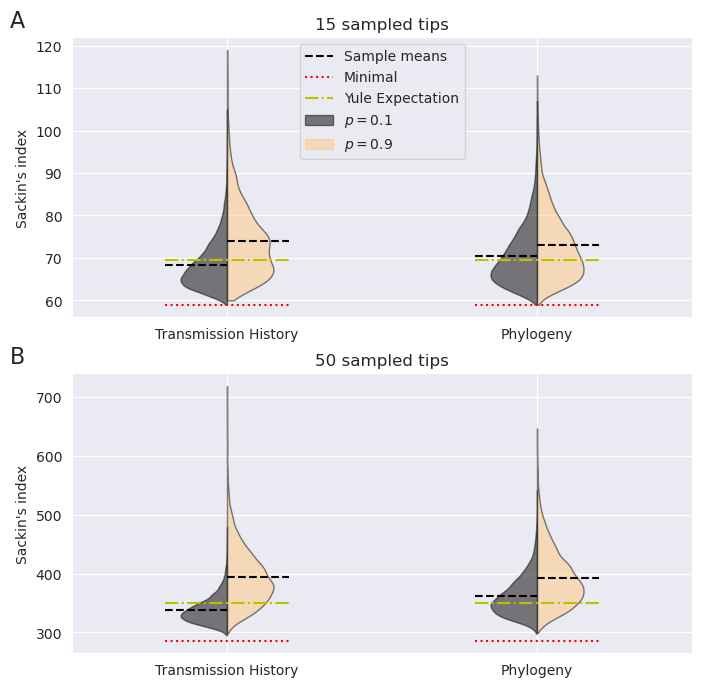

In [34]:
norm = colors.Normalize(vmin=0, vmax=1)
# cmap_fn = cm.get_cmap('plasma_r')
cmap_fn = cm.get_cmap('copper')
## 0 and 1
sz = 50
xv = np.linspace(1.5, 5, 400)
models = {}
alpha=0.15
cmap='plasma_r'
ylabel = "Sackin index"

sackin_optimal_50 = 286  # via OEIS:A003314/list
sackin_optimal_15 = 59   # via OEIS:A003314/list
sackin_yule_mean_50, sackin_yule_var_50 = SackinYule(50)
sackin_yule_mean_15, sackin_yule_var_15 = SackinYule(15)
sackin_uniform_mean_50, sackin_uniform_var_50 = SackinUniform(50)
sackin_uniform_mean_15, sackin_uniform_var_15 = SackinUniform(15)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,8))
discovery_p = dataDict[15].contact_tracing_p[0]
alpha=0.2
# 
ims = []

# ax['a)'].set_ylim(0, 650)
n=40
x50 = np.linspace(sackin_optimal_50 * 0.95, 650, n)
x15 = np.linspace(sackin_optimal_15 * 0.95, 130, n)
yv = np.linspace(1.5, 5, n)
# cmax = [60, 40, 60, 40]
colors_list = [cmap_fn(norm(0)), cmap_fn(norm(1))]
plothelper5(df=df_all, left_key = "Transmission History", right_key="Phylogeny", 
            ct_p=[0.1, 0.9], sz=15, c=colors_list, ax=ax[0], 
            sackin_opt=sackin_optimal_15, sackin_yule_mean=sackin_yule_mean_15, 
            legend=True)

plothelper5(df=df_all, left_key = "Transmission History", right_key="Phylogeny", 
            ct_p=[0.1, 0.9], sz=50, c=colors_list, ax=ax[1], 
            sackin_opt=sackin_optimal_50, sackin_yule_mean=sackin_yule_mean_50)
# Place letters on the plots
ax[0].text(-0.1, 1.1, "A", transform=ax[0].transAxes, fontsize=16, va='top', ha='left')
ax[1].text(-0.1, 1.1, "B", transform=ax[1].transAxes, fontsize=16, va='top', ha='left')
for ext in ["pdf", "eps", "svg", "png"]:
    pass
    # plt.savefig(f"../Figures/Prod/SackinsViolin_5.{ext}", dpi=300)
plt.show()
